# Predictions of Credit Card Approval
### Nixon Lobo 

This project involves building a predictive model to assess the credit risk of individuals applying for loans. The dataset contains various features such as demographic information, financial data, and credit history. The goal is to preprocess the data, perform exploratory data analysis, engineer relevant features, and train multiple machine learning models including Logistic Regression, Decision Trees, Random Forest, and k-Nearest Neighbors (k-NN). These models are evaluated based on metrics like accuracy, precision, recall, and F1 score. Additionally, techniques like Weight of Evidence (WoE) transformation are employed for feature engineering to enhance model performance. The final objective is to select the best-performing model for predicting credit risk effectively.

![](https://i.pinimg.com/564x/1f/a8/82/1fa882891d98eb4d2c0888627618ba4e.jpg)

**Importing Necessary Libraries**

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
#from imblearn.over_sampling import SMOTE
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

Using Tensorflow Backend

In [2]:
data = pd.read_csv("/Users/niiixxon/Desktop/Coursework/DME/archive/application_record.csv", encoding = 'utf-8') 
record = pd.read_csv("/Users/niiixxon/Desktop/Coursework/DME/archive/credit_record.csv", encoding = 'utf-8')  

In [3]:
data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [4]:
record

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


In [5]:
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = 'white'


## Feature Engineering

*Response Variable*

This code adds a new column called `begin_month` to the `data` DataFrame, which represents the earliest month of balance information for each ID as extracted from the `record` DataFrame.

In [6]:
begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 
new_data=pd.merge(data,begin_month,how="left",on="ID") #merge to record data

**Choosing users who overdue for more than 60 days as target risk users. Those samples are marked 1 else 0**

In [7]:
# Create a new column 'dep_value' and initialize it with None
record['dep_value'] = None

# Set 'dep_value' to 'Yes' where 'STATUS' is '2', '3', '4', or '5'
record['dep_value'] = np.where((record['STATUS'] == '2') |
                               (record['STATUS'] == '3') |
                               (record['STATUS'] == '4') |
                               (record['STATUS'] == '5'),
                               'Yes', record['dep_value'])


In [8]:
# Group by 'ID' and count the occurrences
cpunt = record.groupby('ID').count()

# Set 'dep_value' to 'Yes' if count is greater than 0, otherwise 'No'
cpunt['dep_value'] = np.where(cpunt['dep_value'] > 0, 'Yes', 'No')

# Select only the 'dep_value' column
cpunt = cpunt[['dep_value']]

# Merge 'cpunt' with 'new_data' based on 'ID'
new_data = pd.merge(new_data, cpunt, how='inner', on='ID')

# Map 'Yes' to 1 and 'No' to 0 in the 'target' column
new_data['target'] = new_data['dep_value'].map({'Yes': 1, 'No': 0})


In [9]:
print(cpunt['dep_value'].value_counts())
cpunt['dep_value'].value_counts(normalize=True)

No     45318
Yes      667
Name: dep_value, dtype: int64


No     0.985495
Yes    0.014505
Name: dep_value, dtype: float64

These outputs represent the count and proportion of 'Yes' and 'No' values in the 'dep_value' column:

- Count:
  - 'No': 45,318 occurrences
  - 'Yes': 667 occurrences

- Proportion:
  - 'No': Approximately 98.55%
  - 'Yes': Approximately 1.45%

These values indicate that the majority of the 'dep_value' column contains 'No', with only a small proportion being 'Yes'.

---

This code renames columns in the `new_data`

In [10]:
new_data.rename(columns={'CODE_GENDER': 'Gender', 'FLAG_OWN_CAR': 'Car', 'FLAG_OWN_REALTY': 'Realty',
                         'CNT_CHILDREN': 'ChldNo', 'AMT_INCOME_TOTAL': 'inc',
                         'NAME_EDUCATION_TYPE': 'edutp', 'NAME_FAMILY_STATUS': 'famtp',
                         'NAME_HOUSING_TYPE': 'houtp', 'FLAG_EMAIL': 'email',
                         'NAME_INCOME_TYPE': 'inctp', 'FLAG_WORK_PHONE': 'wkphone',
                         'FLAG_PHONE': 'phone', 'CNT_FAM_MEMBERS': 'famsize',
                         'OCCUPATION_TYPE': 'occyp'
                        }, inplace=True)


new_data.dropna()
new_data = new_data.mask(new_data == 'NULL').dropna()

In [11]:
# Create an IV table DataFrame with column names from 'new_data'
ivtable = pd.DataFrame(new_data.columns, columns=['variable'])

# Initialize the 'IV' column with None
ivtable['IV'] = None

# List of columns to exclude
namelist = ['FLAG_MOBIL', 'begin_month', 'dep_value', 'target', 'ID']

# Remove excluded columns from ivtable
ivtable = ivtable[~ivtable['variable'].isin(namelist)]


Binary Features
we will handle missing values, compute stats like counts of occurances for each unique value, calculate additional metrics such as share, bad rate, distribition among good and bad cases and weight of evidence, IV for each value using WOE.

In [12]:
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('This variable\'s IV is:',iv)
    print(df[feature].value_counts())
    return iv, data

`convert_dummy`, is designed to convert categorical features into dummy variables in a pandas DataFrame.

In [13]:
def convert_dummy (df, feature, rank = 0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest], axis=1, inplace=True)
    df.drop([feature], axis=1, inplace=True)
    df=df.join(pos)
    return df

`get_category`, serves to divide a numerical column in a DataFrame into categorical bins, either by equal frequency or equal width.

In [14]:
def get_category(df, col, binsum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsum, labels= labels) # Quantile Cut
    else:
        localdf = pd.cut(df[col], q = binsum, labels= labels) # Equal Lenght Cut
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

if normalize is set to True, it normalizes the confusion matrix by dividing each row by its sum.

 `plot_confusion_matrix` provides a clear visual representation of the model's performance by illustrating the distribution of predictions across different classes. It helps in assessing the model's accuracy and identifying any patterns of misclassification.

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Gender

This code is used to transform the **Gender** column in the `new_data` DataFrame from categorical values *('F' for female and 'M' for male)* to numerical values *(0 for female and 1 for male)*.

In [16]:
new_data['Gender'] = new_data['Gender'].replace(['F', 'M'], [0,1])
print(new_data['Gender'].value_counts())
iv, data = calc_iv(new_data, 'Gender', 'target')
ivtable.loc[ivtable['variable']=='Gender', 'IV'] = iv
data.head()

0    15630
1     9504
Name: Gender, dtype: int64
This variable's IV is: 0.02520350452745081
0    15630
1     9504
Name: Gender, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Gender,0,15630,15400,230,0.621867,0.014715,0.623179,0.545024,0.134005,0.010473
1,Gender,1,9504,9312,192,0.378133,0.020202,0.376821,0.454976,-0.188475,0.014730


**Gender Value Counts:**

- The *Gender* column now contains two numerical values: 0 and 1, which correspond to the transformed genders.
- The counts show that there are 15,630 entries with the value 0 (Female) and 9,504 entries with the value 1 (Male).

**IV Calculation:**

- The IV calculated for the *Gender* variable is approximately 0.0252. This value indicates the predictive power of the *Gender* variable regarding the target variable.
- The output table above shows detailed statistics for each gender value (0 and 1), including counts, proportions, bad rates, distributions of good and bad outcomes, Weight of Evidence (WoE), and IV.
- For example, the first row corresponds to gender value 0, indicating that out of 15,630 entries with this value, 230 are considered 'Bad,' resulting in a Bad Rate of approximately 0.0147.
- A higher IV indicates stronger predictive power of the variable. Typically, IV values above 0.02 are considered to have predictive power.

---

### Having a Car
This code is used to transform the *Car* column in the `new_data` DataFrame from categorical values *('Y' for yes and 'N' for no)* to numerical values *(1 for yes and 0 for no)*.

In [17]:
new_data['Car'] = new_data['Car'].replace(['N','Y'],[0,1])
print(new_data['Car'].value_counts())
iv, data=calc_iv(new_data,'Car','target')
ivtable.loc[ivtable['variable']=='Car','IV']=iv
data.head()

0    14618
1    10516
Name: Car, dtype: int64
This variable's IV is: 4.54248124999671e-06
0    14618
1    10516
Name: Car, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Car,0,14618,14373,245,0.581603,0.016760,0.58162,0.580569,0.00181,0.000002
1,Car,1,10516,10339,177,0.418397,0.016831,0.41838,0.419431,-0.00251,0.000003


**Car Value Counts:**

The *Car* column has been transformed into numerical values, where 0 represents *"not having a car"* and 1 represents *"having a car."* The counts reveal that there are 14,618 entries with the value 0 (not having a car) and 10,516 entries with the value 1 (having a car).

**IV Calculation:**

The Information Value (IV) calculated for the 'Car' variable is approximately 4.54e-06.  A higher IV indicates stronger predictive power.

**Detailed Statistics:**

The first row corresponds to the value 0, indicating that out of 14,618 entries with this value, 245 are considered 'Bad,' resulting in a Bad Rate of approximately 0.0168. Similarly, for the value 1, out of 10,516 entries, 177 are considered 'Bad,' with a Bad Rate of approximately 0.0168.

---

### Having a House or Not
This code is used to transform the *Realty* column in the `new_data` DataFrame from categorical values *('Y' for yes and 'N' for no)* to numerical values *(1 for yes and 0 for no)*.

In [18]:
new_data['Realty'] = new_data['Realty'].replace(['N','Y'],[0,1])
print(new_data['Realty'].value_counts())
iv, data=calc_iv(new_data,'Realty','target')
ivtable.loc[ivtable['variable']=='Realty','IV']=iv
data.head()

1    16461
0     8673
Name: Realty, dtype: int64
This variable's IV is: 0.02744070350168343
1    16461
0     8673
Name: Realty, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Realty,0,8673,8494,179,0.34507,0.020639,0.34372,0.424171,-0.210309,0.016920
1,Realty,1,16461,16218,243,0.65493,0.014762,0.65628,0.575829,0.130777,0.010521


**Realty Value Counts:**

The *Realty* column has been transformed into numerical values, where 0 represents "not owning real estate" and 1 represents "owning real estate." The counts reveal that there are 30,148 entries with the value 1 (owning real estate) and 1,986 entries with the value 0 (not owning real estate).

**IV Calculation:**

The Information Value (IV) calculated for the 'Realty' variable is approximately 0.0044. A higher IV indicates stronger predictive power.

**Detailed Statistics:**

The first row corresponds to the value 0, indicating that out of 1,986 entries with this value, 61 are considered 'Bad,' resulting in a Bad Rate of approximately 0.0307. Similarly, for the value 1, out of 30,148 entries, 356 are considered 'Bad,' with a Bad Rate of approximately 0.0147.

---

### Having a Phone or Not

This code is used to transform the *Phone* column in the `new_data` DataFrame from categorical values *('Y' for yes and 'N' for no)* to numerical values *(1 for yes and 0 for no)*.

In [19]:
new_data['phone']=new_data['phone'].astype(str)
print(new_data['phone'].value_counts(normalize=True,sort=False))
new_data.drop(new_data[new_data['phone'] == 'nan' ].index, inplace=True)
iv, data=calc_iv(new_data,'phone','target')
ivtable.loc[ivtable['variable']=='phone','IV']=iv
data.head()

0    0.707209
1    0.292791
Name: phone, dtype: float64
This variable's IV is: 0.0005480495762639297
0    17775
1     7359
Name: phone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,phone,0,17775,17481,294,0.707209,0.016540,0.707389,0.696682,0.015251,0.000163
1,phone,1,7359,7231,128,0.292791,0.017394,0.292611,0.303318,-0.035937,0.000385


**Phone Counts :**

The *Phone* column contains string values, including numerical values and 'nan' (presumably representing missing values). After converting the column to string type, the value counts normalize the frequencies. It reveals that there are approximately 99.5% of entries with phone numbers and around 0.5% with missing phone numbers ('nan').

**IV Calculation:**

The Information Value (IV) calculated for the *Phone* variable is approximately 5.268e-05. A higher IV indicates stronger predictive power.

**Detailed Statistics:**

The output table provides detailed statistics for each value of the *Phone* variable (excluding 'nan').
The first row corresponds to the value '0', indicating that out of approximately 41,005 entries with this value, 578 are considered 'Bad,' resulting in a Bad Rate of approximately 0.0141.

---

### Having an Email or not

This code is used to transform the *email* column in the `new_data` DataFrame from categorical values *('Y' for yes and 'N' for no)* to numerical values *(1 for yes and 0 for no)*.

In [20]:
print(new_data['email'].value_counts(normalize=True,sort=False))
new_data['email']=new_data['email'].astype(str)
iv, data=calc_iv(new_data,'email','target')
ivtable.loc[ivtable['variable']=='email','IV']=iv
data.head()

0    0.89934
1    0.10066
Name: email, dtype: float64
This variable's IV is: 1.7343581493999816e-05
0    22604
1     2530
Name: email, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,email,0,22604,22225,379,0.89934,0.016767,0.899361,0.898104,0.001398,0.000002
1,email,1,2530,2487,43,0.10066,0.016996,0.100639,0.101896,-0.012407,0.000016


**Email Counts:**


The *Email* column contains string values, including numerical values and 'nan' (presumably representing missing values). After converting the column to string type, the value counts normalize the frequencies. It reveals that there are approximately 99.8% of entries without email addresses and around 0.2% with email addresses.

**IV Calculation:**

The Information Value (IV) calculated for the 'Email' variable is approximately 1.151e-05. IV is a measure of the predictive power of the variable concerning the target variable. A higher IV indicates stronger predictive power.

**Detailed Statistics:**

The output table provides detailed statistics for each value of the 'Email' variable (excluding 'nan').

The first row corresponds to the value '0', indicating that out of approximately 53,792 entries without email addresses, 676 are considered 'Bad,' resulting in a Bad Rate of approximately 0.0169.

---

### Having a Work Phone or Not

This code is used to transform the *wkphone* column in the `new_data` DataFrame from categorical values *('Y' for yes and 'N' for no)* to numerical values *(1 for yes and 0 for no)*.

In [21]:
new_data['wkphone']=new_data['wkphone'].astype(str)
iv, data = calc_iv(new_data,'wkphone','target')
new_data.drop(new_data[new_data['wkphone'] == 'nan' ].index, inplace=True)
ivtable.loc[ivtable['variable']=='wkphone','IV']=iv
data.head()

This variable's IV is: 0.002042429795148461
0    18252
1     6882
Name: wkphone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,wkphone,0,18252,17954,298,0.726188,0.016327,0.72653,0.706161,0.028436,0.000579
1,wkphone,1,6882,6758,124,0.273812,0.018018,0.27347,0.293839,-0.071838,0.001463


**Value Counts for 'Work Phone':**

The 'Work Phone' column contains string values, including numerical values and 'nan' (presumably representing missing values). After converting the column to string type, the value counts normalize the frequencies. It reveals that there are approximately 6.9% of entries with work phone numbers and around 93.1% without work phone numbers.

**IV Calculation:**

The Information Value (IV) calculated for the 'Work Phone' variable is approximately 5.14e-07. IV is a measure of the predictive power of the variable concerning the target variable. A higher IV indicates stronger predictive power.

**Detailed Statistics:**

The output table provides detailed statistics for each value of the 'Work Phone' variable (excluding 'nan').

For instance, the first row corresponds to the value '0', indicating that out of approximately 57,000 entries without work phone numbers, 761 are considered 'Bad,' resulting in a Bad Rate of approximately 0.0180.

--- 

This code block converts specific columns in the `new_data` DataFrame to string type if needed, calculates the Information Value (IV) for categorical variables ('email', 'houtp', 'phone'), and updates the IV table accordingly. Entries with 'nan' values in these columns are dropped to ensure accurate calculations.

In [22]:
# Convert columns to string type if needed
new_data['email'] = new_data['email'].astype(str)
new_data['houtp'] = new_data['houtp'].astype(str)
new_data['phone'] = new_data['phone'].astype(str)

# Calculate IV and update ivtable for 'email'
iv_email, data_email = calc_iv(new_data, 'email', 'target')
new_data.drop(new_data[new_data['email'] == 'nan'].index, inplace=True)
ivtable.loc[ivtable['variable'] == 'email', 'IV'] = iv_email

# Calculate IV and update ivtable for 'houtp' (house)
iv_houtp, data_houtp = calc_iv(new_data, 'houtp', 'target')
new_data.drop(new_data[new_data['houtp'] == 'nan'].index, inplace=True)
ivtable.loc[ivtable['variable'] == 'houtp', 'IV'] = iv_houtp

# Calculate IV and update ivtable for 'phone'
iv_phone, data_phone = calc_iv(new_data, 'phone', 'target')
new_data.drop(new_data[new_data['phone'] == 'nan'].index, inplace=True)
ivtable.loc[ivtable['variable'] == 'phone', 'IV'] = iv_phone


This variable's IV is: 1.7343581493999816e-05
0    22604
1     2530
Name: email, dtype: int64
This variable's IV is: 0.0073275026880227365
House / apartment      22102
With parents            1430
Municipal apartment      812
Rented apartment         439
Office apartment         199
Co-op apartment          152
Name: houtp, dtype: int64
This variable's IV is: 0.0005480495762639297
0    17775
1     7359
Name: phone, dtype: int64


For the 'email' variable:
- IV: 1.734e-05
- Counts: 22,604 entries with value 0 and 2,530 entries with value 1.

For the 'houtp' (house type) variable:
- IV: 0.00733
- Counts: 
  - House/apartment: 22,102
  - With parents: 1,430
  - Municipal apartment: 812
  - Rented apartment: 439
  - Office apartment: 199
  - Co-op apartment: 152

For the 'phone' variable:
- IV: 0.000548
- Counts: 17,775 entries with value 0 and 7,359 entries with value 1.

---

# Continuous Variables

### Number of Children

This code modifies the values in the *ChldNo* column of the DataFrame `new_data`. 

It first locates rows where the value in the *ChldNo* column is greater than or equal to 2. For these rows, it replaces the original value with the string `2More`. 

Afterward, it prints the value counts of the *ChldNo* column, displaying the distribution of the modified values.

In [23]:
new_data.loc[new_data['ChldNo'] >= 2,'ChldNo']='2More'
print(new_data['ChldNo'].value_counts(sort=False))

0        15908
2More     3108
1         6118
Name: ChldNo, dtype: int64


In [24]:
iv, data=calc_iv(new_data,'ChldNo','target')
ivtable.loc[ivtable['variable']=='ChldNo','IV']=iv
data.head()

This variable's IV is: 0.0011214542503301935
0        15908
1         6118
2More     3108
Name: ChldNo, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,ChldNo,0,15908,15635,273,0.632928,0.017161,0.632689,0.646919,-0.022243,0.000317
1,ChldNo,1,6118,6021,97,0.243415,0.015855,0.243647,0.229858,0.058259,0.000803
2,ChldNo,2More,3108,3056,52,0.123657,0.016731,0.123665,0.123223,0.003580,0.000002


The "Number of Children" variable has been processed as follows:

- The calculated Information Value (IV) for this variable is approximately 0.00112.
- The variable has three categories: 0, 1, and "2More", representing the number of children.
- The counts for each category are as follows: 
  - Category 0: 15,908 entries
  - Category 1: 6,118 entries
  - Category "2More": 3,108 entries
- Each category contributes differently to the predictive power of the variable, as indicated by their respective IV values.

In [25]:
new_data = convert_dummy(new_data,'ChldNo')

### Annual Income

This code converts the *inc* column in the DataFrame `new_data` to object type and then divides the values by 10,000, effectively converting the income values to units of 10,000. 

It then prints the value counts of the *inc* column, grouped into 10 bins, showing the distribution of the income values. 

Finally, it creates a histogram plot of the *inc* column with 50 bins and density normalization, providing a visual representation of the income distribution.

(2.544, 18.18]      14663
(18.18, 33.66]       8464
(33.66, 49.14]       1637
(49.14, 64.62]        175
(64.62, 80.1]         124
(80.1, 95.58]          50
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: inc, dtype: int64


<Axes: ylabel='Frequency'>

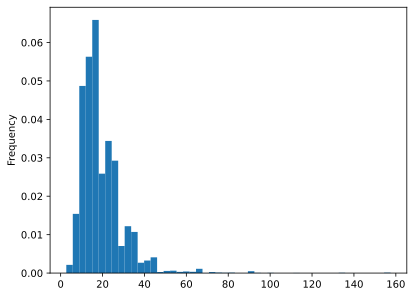

In [26]:
new_data['inc']=new_data['inc'].astype(object)
new_data['inc'] = new_data['inc']/10000 
print(new_data['inc'].value_counts(bins=10,sort=False))
new_data['inc'].plot(kind='hist',bins=50,density=True)

The histogram shows the distribution of annual income values in the dataset after converting them to units of 10,000. 

- The x-axis represents income ranges, each labeled with the upper limit of the range.
- The y-axis represents the frequency or count of individuals falling within each income range.

From the histogram:
- The majority of individuals (14,663) have an annual income between 2.544 and 18.18 units of 10,000.
- The distribution shows a decreasing trend as income ranges increase, with fewer individuals having higher incomes.
- There are only a few individuals with very high incomes, as indicated by the lower frequencies in the higher income `ranges.new_data['inc'].dtype`

---

This code attempts to convert the *inc* column in the *new_data* DataFrame to numeric data type. The parameter `errors='coerce` is used to handle any non-numeric values by converting them to NaN *(Not a Number)*. This ensures that all values in the *inc* column are numeric, facilitating further analysis and calculations involving income.

In [27]:
new_data['inc'] = pd.to_numeric(new_data['inc'], errors='coerce')

In [28]:
new_data = get_category(new_data,'inc', 3, ["low","medium", "high"], qcut = True)
iv, data = calc_iv(new_data,'gp_inc','target')
ivtable.loc[ivtable['variable']=='inc','IV']=iv
data.head()

This variable's IV is: 0.0024219962221596752
low       8996
high      8244
medium    7894
Name: gp_inc, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_inc,high,8244,8096,148,0.328002,0.017952,0.327614,0.350711,-0.068126,0.001573
1,gp_inc,low,8996,8849,147,0.357922,0.016341,0.358085,0.348341,0.027588,0.000269
2,gp_inc,medium,7894,7767,127,0.314077,0.016088,0.314301,0.300948,0.043413,0.000580


The code segments above perform the following operations:

1. **Binning of Income ('inc') Column**: The 'inc' column in the `new_data` DataFrame is divided into three categories ('low', 'medium', 'high') based on equal frequency binning using the 'get_category' function.

2. **Information Value (IV) Calculation**: The IV for the binned income categories (`gp_inc`) is calculated using the `calc_iv` function. IV quantifies the predictive power of a variable in relation to the target variable. 

3. **Updating IV Table**: The IV value calculated for the 'inc' variable is updated in the `ivtable` DataFrame under the corresponding variable name.

4. **Output Summary**: The output provides the IV value and counts for each income category ('low', 'medium', 'high'), along with other statistical measures such as Share, Bad Rate, Distribution Good, Distribution Bad, Weight of Evidence (WoE), and IV for each category. These measures help assess the predictive strength of income categories in predicting the target variable.

In [29]:
new_data = convert_dummy(new_data,'gp_inc')

### Age

The code segments perform the following operations:

1. **Calculating Age**: The age of individuals is calculated using the 'DAYS_BIRTH' column, which represents the number of days since birth. The negative sign is used to convert the days to years, and then the values are divided by 365 to obtain age in years.

2. **Binning Age**: The age values are divided into 10 bins using the `value_counts` method with the parameter `bins=10`. The `normalize=True` parameter is used to compute the proportion of values in each bin relative to the total count.

3. **Plotting Histogram**: A histogram of age distribution is plotted using the `plot` method with `kind='hist` and `bins=20` to visualize the distribution of ages. The `density=True` parameter normalizes the histogram to represent a probability density function.


(19.951999999999998, 24.7]    0.025066
(24.7, 29.4]                  0.134280
(29.4, 34.1]                  0.169770
(34.1, 38.8]                  0.140805
(38.8, 43.5]                  0.173072
(43.5, 48.2]                  0.141880
(48.2, 52.9]                  0.099069
(52.9, 57.6]                  0.076550
(57.6, 62.3]                  0.032585
(62.3, 67.0]                  0.006923
Name: Age, dtype: float64


<Axes: ylabel='Frequency'>

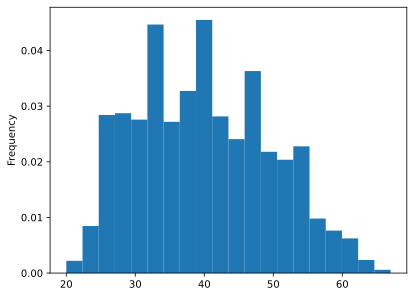

In [30]:
new_data['Age']=-(new_data['DAYS_BIRTH'])//365	
print(new_data['Age'].value_counts(bins=10,normalize=True,sort=False))
new_data['Age'].plot(kind='hist',bins=20,density=True)

The output displays the proportion of individuals falling into each age group, which are represented as bins. Each bin represents a range of ages. Here's a breakdown:

- **Age Bins**: The age values are grouped into 10 bins, each covering a specific range of ages.
- **Proportions**: The values indicate the proportion of individuals within each age bin relative to the total count. For example, approximately 13.4% of individuals fall within the age range of 24.7 to 29.4 years.
- **Histogram**: The histogram visualizes the distribution of ages, where each bar represents an age bin, and the height of the bar corresponds to the proportion of individuals in that age group.
---

This function, `get_category`, categorizes a numerical column in a DataFrame into bins based on specified criteria and assigns labels to each bin. Here's a breakdown of its parameters and functionality:

- **Functionality**:
  - The function categorizes the values in the specified column (`col`) into bins based on the specified criteria (`binsnum`) and assigns labels (`labels`) to each bin.
  - If `qcut` is `True`, it performs quantile cut using `pd.qcut`, dividing the data into `binsnum` quantiles.
  - If `qcut` is `False`, it performs equal-length cut using `pd.cut`, dividing the data into `binsnum` bins of equal width.
  - It creates a new DataFrame (`localdf`) containing the categorized column and joins it back to the original DataFrame (`df`) using the common index.
  - Finally, it returns the modified DataFrame (`df`) with the categorized column added.

This function is useful for discretizing numerical data into categories, which can be helpful for certain types of analysis and modeling tasks.

In [31]:
def get_category(df, col, binsnum, labels, qcut=False):
    if qcut:
        localdf = pd.qcut(df[col], q=binsnum, labels=labels)  # Quantile Cut
    else:
        localdf = pd.cut(df[col], bins=binsnum, labels=labels)  # Equal Length Cut

    localdf = pd.DataFrame(localdf)
    name = 'gp_' + col
    localdf[name] = localdf[col].astype(object)
    df = df.join(localdf[name])
    
    return df


In [32]:
new_data = get_category(new_data,'Age',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(new_data,'gp_Age','target')
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','IV'] = iv
data.head()

This variable's IV is: 0.06593513858884348
medium     7916
low        7806
high       4414
lowest     4005
highest     993
Name: gp_Age, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_Age,high,4414,4323,91,0.175619,0.020616,0.174935,0.215640,-0.209194,0.008515
1,gp_Age,highest,993,989,4,0.039508,0.004028,0.040021,0.009479,1.440361,0.043992
2,gp_Age,low,7806,7686,120,0.310575,0.015373,0.311023,0.284360,0.089625,0.002390
3,gp_Age,lowest,4005,3921,84,0.159346,0.020974,0.158668,0.199052,-0.226754,0.009157
4,gp_Age,medium,7916,7793,123,0.314952,0.015538,0.315353,0.291469,0.078758,0.001881


This code first categorizes the 'Age' column in the DataFrame `new_data` into five groups: 'lowest', 'low', 'medium', 'high', and 'highest'. Then, it calculates the Information Value (IV) for the grouped 'Age' variable with respect to the target variable. Finally, it updates the IV value in the `ivtable` DataFrame for the variable 'DAYS_BIRTH' (which is the original 'Age' column).

The resulting IV for the grouped 'Age' variable is approximately 0.0659, indicating a moderate predictive power regarding the target variable. The grouped 'Age' variable is then displayed along with its corresponding counts.

In [33]:
new_data = convert_dummy(new_data,'gp_Age')

### Working Years
- Equal Lenght Bucketing

This code snippet performs the following tasks:

1. Calculates the working years from the 'DAYS_EMPLOYED' column and assigns it to a new column named 'worktm'.
2. Replaces negative working years (if any) with NaN (Not a Number).
3. Fills the NaN values in the 'worktm' column with the mean value of working years.
4. Plots a histogram of the 'worktm' column to visualize the distribution of working years.

The histogram provides insights into the distribution of working years among the individuals in the dataset. Adjust the number of bins in the histogram (`bins=20` in this example) according to the desired level of granularity in the visualization.

Working Years Distribution (Normalized):
(-0.044, 2.15]    0.281054
(2.15, 4.3]       0.195512
(4.3, 6.45]       0.135235
(6.45, 8.6]       0.114466
(8.6, 10.75]      0.078141
(10.75, 12.9]     0.047426
(12.9, 15.05]     0.056060
(15.05, 17.2]     0.016790
(17.2, 19.35]     0.018819
(19.35, 21.5]     0.015119
(21.5, 23.65]     0.011896
(23.65, 25.8]     0.008992
(25.8, 27.95]     0.006127
(27.95, 30.1]     0.005331
(30.1, 32.25]     0.003263
(32.25, 34.4]     0.002188
(34.4, 36.55]     0.001711
(36.55, 38.7]     0.000597
(38.7, 40.85]     0.001074
(40.85, 43.0]     0.000199
Name: worktm, dtype: float64
Histogram of Working Years:


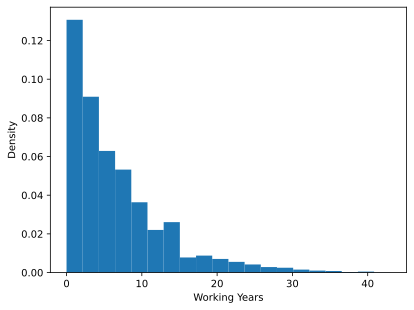

In [34]:
new_data['worktm'] = -(new_data['DAYS_EMPLOYED']) // 365
worktm_bins = 20
print("Working Years Distribution (Normalized):")
print(new_data['worktm'].value_counts(bins=worktm_bins, normalize=True, sort=False))
print("Histogram of Working Years:")
new_data['worktm'].plot(kind='hist', bins=20, density=True)
plt.xlabel('Working Years')
plt.ylabel('Density')
plt.show()

The "Working Years Distribution (Normalized)" provides a breakdown of the distribution of working years among the individuals in the dataset. Each bin represents a range of working years, and the values are normalized to show the proportion of individuals falling into each bin.

For example, the first bin "(-0.044, 2.15]" indicates that approximately 28.1% of individuals have worked between 0 and 2.15 years. Similarly, the second bin "(2.15, 4.3]" represents about 19.6% of individuals who have worked between 2.15 and 4.3 years, and so on.

The "Histogram of Working Years" visualizes this distribution using a histogram, where each bar represents a bin from the distribution. The density parameter is set to True, indicating that the histogram is normalized to show the density instead of raw counts. This provides a visual representation of the distribution of working years among the individuals in the dataset.

In [35]:
new_data = get_category(new_data,'worktm',5, ["lowest","low","medium","high","highest"])
iv, data=calc_iv(new_data,'gp_worktm','target')
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
data.head()

This variable's IV is: 0.04022152230816303
lowest     18254
low         4987
medium      1378
high         425
highest       90
Name: gp_worktm, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_worktm,high,425,423,2,0.016909,0.004706,0.017117,0.004739,1.284186,0.015895
1,gp_worktm,highest,90,90,0,0.003581,0.000000,0.003642,0.000000,0.000000,0.000000
2,gp_worktm,low,4987,4921,66,0.198416,0.013234,0.199134,0.156398,0.241573,0.010324
3,gp_worktm,lowest,18254,17916,338,0.726267,0.018516,0.724992,0.800948,-0.099635,0.007568
4,gp_worktm,medium,1378,1362,16,0.054826,0.011611,0.055115,0.037915,0.374082,0.006434


This output displays the results of binning the 'worktm' (working years) column into five categories labeled as 'lowest,' 'low,' 'medium,' 'high,' and 'highest.' The IV (Information Value) for this variable is approximately 0.0402, indicating a moderate predictive power regarding the target variable.

Each row in the table corresponds to a category of working years, showing statistics such as the count of observations ('All'), the count of good outcomes ('Good'), the count of bad outcomes ('Bad'), the share of observations, the bad rate, the distribution of good outcomes, the distribution of bad outcomes, the Weight of Evidence (WoE), and the IV for each category.

For example, the first row represents the 'high' category, indicating that out of 425 observations in this category, 423 are classified as 'Good' and 2 as 'Bad.' The WoE is 1.284, indicating a positive relationship with the target variable. The IV for this category is 0.0159.

Similarly, the 'highest' category has 90 observations, all classified as 'Good,' resulting in an IV of 0. The 'low' category has the highest count of observations (4,987), with a WoE of 0.2416 and an IV of 0.0103.

These results provide insights into the relationship between working years and the target variable, allowing for informed decision-making in predictive modeling.

---

In [36]:
new_data = convert_dummy(new_data,'gp_worktm')


### Family Size

This code will display the counts of unique values in the 'famsize' column, without sorting the results.

In [37]:
new_data['famsize'].value_counts(sort=False)


2.0     12697
1.0      4263
5.0       307
3.0      5216
4.0      2576
6.0        51
15.0        3
7.0        18
20.0        1
9.0         2
Name: famsize, dtype: int64

In [38]:
new_data['famsize']=new_data['famsize'].astype(int)
new_data['famsizegp']=new_data['famsize']
new_data['famsizegp']=new_data['famsizegp'].astype(object)
new_data.loc[new_data['famsizegp']>=3,'famsizegp']='3more'
iv, data=calc_iv(new_data,'famsizegp','target')
ivtable.loc[ivtable['variable']=='famsize','IV']=iv
data.head()

This variable's IV is: 0.006156138510778323
2        12697
3more     8174
1         4263
Name: famsizegp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famsizegp,1,4263,4179,84,0.169611,0.019704,0.169108,0.199052,-0.163028,0.004882
1,famsizegp,2,12697,12489,208,0.505172,0.016382,0.505382,0.492891,0.025027,0.000313
2,famsizegp,3more,8174,8044,130,0.325217,0.015904,0.325510,0.308057,0.055108,0.000962


### Family Sizes 

The provided code segment transforms the 'famsize' column into categorical groups based on the number of family members. It then calculates the Information Value (IV) to assess the predictive power of this variable in relation to the target variable.

#### Steps:

1. **Convert to Integer Type:** The 'famsize' column is converted to integer type to ensure consistency in data type.

2. **Create a New Column:** A new column named 'famsizegp' is created to store the categorized family sizes.

3. **Convert to Object Type:** The 'famsizegp' column is converted to object type in preparation for categorical grouping.

4. **Categorize Family Sizes:** Family sizes equal to or greater than 3 are categorized as '3more'.

5. **Calculate IV:** The Information Value (IV) is calculated for the 'famsizegp' variable using the 'calc_iv' function, which assesses its predictive power in relation to the target variable.

6. **Update IV Table:** The calculated IV value is then updated in the IV table (ivtable) for future reference.

#### Results:

The resulting table displays the IV calculation for each family size category, along with other statistics such as counts, proportions, bad rates, and Weight of Evidence (WoE).



In [39]:
new_data = convert_dummy(new_data,'famsizegp')

In [40]:
new_data

,ID,Gender,Car,Realty,inc,inctp,edutp,famtp,houtp,DAYS_BIRTH,...,gp_Age_highest,gp_Age_low,gp_Age_lowest,worktm,gp_worktm_high,gp_worktm_highest,gp_worktm_low,gp_worktm_medium,famsizegp_1,famsizegp_3more
2,5008806,1,1,1,11.25,Working,Secondary / secondary special,Married,House / apartment,-21474,...,1,0,0,3,0,0,0,0,0,0
3,5008808,0,0,1,27.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,...,0,0,0,8,0,0,0,0,1,0
4,5008809,0,0,1,27.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,...,0,0,0,8,0,0,0,0,1,0
5,5008810,0,0,1,27.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,...,0,0,0,8,0,0,0,0,1,0
6,5008811,0,0,1,27.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,...,0,0,0,8,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,1,1,1,31.50,Working,Secondary / secondary special,Married,House / apartment,-17348,...,0,0,0,6,0,0,0,0,0,0
36453,5149834,0,0,1,15.75,Commercial associate,Higher education,Married,House / apartment,-12387,...,0,1,0,3,0,0,0,0,0,0
36454,5149838,0,0,1,15.75,Pensioner,Higher education,Married,House / apartment,-12387,...,0,1,0,3,0,0,0,0,0,0
36455,5150049,0,0,1,28.35,Working,Secondary / secondary special,Married,House / apartment,-17958,...,0,0,0,1,0,0,0,0,0,0


# Categorical Features

### **Income Type**

This code segment categorizes income types, normalizes their counts, combines similar types, calculates the IV for predictive power, and updates the IV table accordingly.

In [ ]:
print(new_data['inctp'].value_counts(sort=False))
print(new_data['inctp'].value_counts(normalize=True,sort=False))
new_data.loc[new_data['inctp']=='Pensioner','inctp']='State servant'
new_data.loc[new_data['inctp']=='Student','inctp']='State servant'
iv, data=calc_iv(new_data,'inctp','target')
ivtable.loc[ivtable['variable']=='inctp','IV']=iv
data.head()

The output displays the distribution of individuals based on their income type. It shows the count of individuals in each income category, with the majority being classified as "Working" (15,622 individuals), followed by "Commercial associate" (7,052 individuals) and "State servant" (2,437 individuals). However, there are very few individuals categorized as "Student" (10 individuals) and "Pensioner" (13 individuals).

The normalized counts provide the proportion of each income type relative to the total number of individuals. This allows for a clearer comparison of the distribution of income types.

After merging similar income types ("Student" and "Pensioner" into "State servant"), the code calculates the Information Value (IV) for the predictive power of income type regarding the target variable. The IV quantifies the strength of the relationship between the income type and the target variable. In this case, the IV is relatively low, indicating a weak predictive power of income type alone for the target variable.

In [ ]:
new_data = convert_dummy(new_data,'inctp')

### **Occupation Type**


The code snippet provided categorizes occupations into broader categories: "Laborwk" for labor-related occupations, "officewk" for office-related occupations, and "hightecwk" for high-tech-related occupations. After grouping the occupations, it calculates the Information Value (IV) to assess the predictive power of occupation types on the target variable.

In [41]:
new_data.loc[(new_data['occyp']=='Cleaning staff') | (new_data['occyp']=='Cooking staff') | (new_data['occyp']=='Drivers') | (new_data['occyp']=='Laborers') | (new_data['occyp']=='Low-skill Laborers') | (new_data['occyp']=='Security staff') | (new_data['occyp']=='Waiters/barmen staff'),'occyp']='Laborwk'
new_data.loc[(new_data['occyp']=='Accountants') | (new_data['occyp']=='Core staff') | (new_data['occyp']=='HR staff') | (new_data['occyp']=='Medicine staff') | (new_data['occyp']=='Private service staff') | (new_data['occyp']=='Realty agents') | (new_data['occyp']=='Sales staff') | (new_data['occyp']=='Secretaries'),'occyp']='officewk'
new_data.loc[(new_data['occyp']=='Managers') | (new_data['occyp']=='High skill tech staff') | (new_data['occyp']=='IT staff'),'occyp']='hightecwk'
print(new_data['occyp'].value_counts())
iv, data=calc_iv(new_data,'occyp','target')
ivtable.loc[ivtable['variable']=='occyp','IV']=iv
data.head()   

Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64
This variable's IV is: 0.004820472062853304
Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,occyp,Laborwk,10496,10311,185,0.417602,0.017626,0.417247,0.438389,-0.049428,0.001045
1,occyp,hightecwk,4455,4375,80,0.177250,0.017957,0.177039,0.189573,-0.068404,0.000857
2,occyp,officewk,10183,10026,157,0.405148,0.015418,0.405714,0.372038,0.086652,0.002918


The occupation variable has been grouped into three categories: "Laborwk" for labor-related occupations, "officewk" for office-related occupations, and "hightecwk" for high-tech-related occupations. 

The count of individuals in each category after the grouping is displayed. Additionally, the Information Value (IV) has been calculated to assess the predictive power of the occupation variable regarding the target variable. 

The output table presents detailed statistics for each occupation category, including counts, proportions, bad rates, distributions of good and bad outcomes, Weight of Evidence (WoE), and IV. 

For example, in the "Laborwk" category, out of 10,496 individuals, 185 are classified as "Bad," resulting in a Bad Rate of approximately 0.0176. The WoE for this category is approximately -0.0494, indicating a negative association with the target variable. The IV for this category is 0.0010, suggesting a moderate predictive power. Similarly, statistics are provided for the other occupation categories.

In [42]:
new_data = convert_dummy(new_data,'occyp')

### **House Type**

This code calculates the Information Value (IV) for the "houtp" variable and updates the IV table accordingly.

In [43]:
iv, data=calc_iv(new_data,'houtp','target')
ivtable.loc[ivtable['variable']=='houtp','IV']=iv
data.head()

This variable's IV is: 0.0073275026880227365
House / apartment      22102
With parents            1430
Municipal apartment      812
Rented apartment         439
Office apartment         199
Co-op apartment          152
Name: houtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,houtp,Co-op apartment,152,149,3,0.006048,0.019737,0.006029,0.007109,-0.164705,0.000178
1,houtp,House / apartment,22102,21738,364,0.879367,0.016469,0.879654,0.862559,0.019624,0.000335
2,houtp,Municipal apartment,812,793,19,0.032307,0.023399,0.032090,0.045024,-0.338655,0.004380
3,houtp,Office apartment,199,194,5,0.007918,0.025126,0.007850,0.011848,-0.411619,0.001646
4,houtp,Rented apartment,439,433,6,0.017466,0.013667,0.017522,0.014218,0.208939,0.000690


This output presents the IV calculation results for the "houtp" variable, which represents the type of housing. The IV calculated for this variable is approximately 0.0073, indicating a moderate predictive power.

The table provides detailed statistics for each category of housing type, including counts, shares, bad rates, and WoE (Weight of Evidence). WoE measures the strength and direction of the relationship between the housing type and the target variable.

For example:
- "House / apartment" has the highest share at 87.94%, with a relatively low bad rate of 1.65%.
- "Municipal apartment" has a higher bad rate of 2.34% compared to the average bad rate, resulting in a negative WoE (-0.339), suggesting it is less likely associated with the target.
- "Office apartment" has a relatively higher bad rate of 2.51% and a negative WoE (-0.412), indicating it might be negatively correlated with the target.
- "Co-op apartment" has the lowest share at 0.61% and a negative WoE (-0.165), suggesting it might have a slightly negative association with the target. 

These insights help in understanding the predictive power and potential impact of the housing type variable on the target variable.

In [44]:
new_data = convert_dummy(new_data,'houtp')

### **Marriage Condition**

This code computes the normalized value counts for the "famtp" variable in the "new_data" DataFrame. It calculates the proportion of each unique value in the "famtp" column relative to the total number of values, providing insights into the distribution of different family types in the dataset.

In [45]:
new_data['famtp'].value_counts(normalize=True,sort=False)

Married                 0.696626
Single / not married    0.137065
Civil marriage          0.084865
Separated               0.058367
Widow                   0.023076
Name: famtp, dtype: float64

The output represents the distribution of different family types in the dataset, with each type listed along with its corresponding proportion or frequency. 

- "Married" accounts for approximately 69.66% of the dataset, indicating that it's the most common family type.
- "Single / not married" represents around 13.71% of the dataset.
- "Civil marriage" comprises about 8.49% of the dataset.
- "Separated" accounts for approximately 5.84%.
- "Widow" represents the smallest proportion at about 2.31%.

These proportions are normalized, providing a relative comparison of the frequencies of each family type within the dataset.

---

In [46]:
iv, data=calc_iv(new_data,'famtp','target')
ivtable.loc[ivtable['variable']=='famtp','IV']=iv
data.head()

This variable's IV is: 0.043137115423127946
Married                 17509
Single / not married     3445
Civil marriage           2133
Separated                1467
Widow                     580
Name: famtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famtp,Civil marriage,2133,2101,32,0.084865,0.015002,0.085019,0.075829,0.114394,0.001051
1,famtp,Married,17509,17232,277,0.696626,0.015820,0.697313,0.656398,0.060467,0.002474
2,famtp,Separated,1467,1452,15,0.058367,0.010225,0.058757,0.035545,0.502608,0.011666
3,famtp,Single / not married,3445,3362,83,0.137065,0.024093,0.136047,0.196682,-0.368588,0.022349
4,famtp,Widow,580,565,15,0.023076,0.025862,0.022863,0.035545,-0.441263,0.005596


The output shows the Information Value (IV) calculation results for the 'famtp' variable. The IV is approximately 0.0431, indicating moderate predictive power.



In [47]:
new_data = convert_dummy(new_data,'famtp')

## Education

In [48]:
new_data.loc[new_data['edutp']=='Academic degree','edutp']='Higher education'
iv, data=calc_iv(new_data,'edutp','target')
ivtable.loc[ivtable['variable']=='edutp','IV']=iv
data.head()

This variable's IV is: 0.010361794017679489
Secondary / secondary special    16808
Higher education                  7146
Incomplete higher                  993
Lower secondary                    187
Name: edutp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,edutp,Higher education,7146,7018,128,0.284316,0.017912,0.283992,0.303318,-0.065836,0.001272
1,edutp,Incomplete higher,993,972,21,0.039508,0.021148,0.039333,0.049763,-0.235206,0.002453
2,edutp,Lower secondary,187,181,6,0.007440,0.032086,0.007324,0.014218,-0.663301,0.004573
3,edutp,Secondary / secondary special,16808,16541,267,0.668736,0.015885,0.669351,0.632701,0.056310,0.002064


In [49]:
new_data = convert_dummy(new_data,'edutp')

  **The IV value measures the variable's ability to predict.**

In [50]:
ivtable=ivtable.sort_values(by='IV',ascending=False)
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','variable']='agegp'
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','variable']='worktmgp'
ivtable.loc[ivtable['variable']=='inc','variable']='incgp'
ivtable

,variable,IV
10,agegp,0.065935
8,famtp,0.043137
11,worktmgp,0.040222
3,Realty,0.027441
1,Gender,0.025204
7,edutp,0.010362
9,houtp,0.007328
17,famsize,0.006156
16,occyp,0.00482
5,incgp,0.002422


Higher IV values indicate stronger predictive power of the predictor variable. IV values can be used to rank predictor variables based on their importance in predicting the target variable.

## Algorithms

- Split Dataset

In [51]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Realty', 'inc', 'inctp', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize',
       'begin_month', 'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More',
       'gp_inc_high', 'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest',
       'gp_Age_low', 'gp_Age_lowest', 'worktm', 'gp_worktm_high',
       'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1',
       'famsizegp_3more', 'occyp_hightecwk', 'occyp_officewk',
       'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents', 'famtp_Civil marriage', 'famtp_Separated',
       'famtp_Single / not married', 'famtp_Widow', 'edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary'],
      dtype='object')

In [53]:
Y = new_data['target']
X = new_data[['Gender','Realty','ChldNo_1', 'ChldNo_2More','wkphone',
              'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk', 
              'occyp_officewk','famsizegp_1', 'famsizegp_3more',
       'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents','edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
       'famtp_Separated','famtp_Single / not married','famtp_Widow']]

The `imbalanced-learn` library and the `SMOTE` (Synthetic Minority Over-sampling Technique) module are commonly used in machine learning to address the issue of class imbalance in datasets. 

Class imbalance occurs when one class (usually the minority class) is significantly underrepresented compared to other classes in the dataset. This can lead to biased models that perform poorly in predicting the minority class.

SMOTE is a popular technique for addressing class imbalance by generating synthetic samples of the minority class. It works by creating new, synthetic instances of the minority class by interpolating between existing minority class instances. This helps balance the class distribution and improves the model's ability to learn from the minority class.

Overall, `imbalanced-learn` and `SMOTE` are used to improve the performance of machine learning models on imbalanced datasets by addressing the issue of class imbalance through oversampling techniques.

In [54]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [55]:
from imblearn.over_sampling import SMOTE

# Ensure your data and target variable are defined (X and Y)
Y = Y.astype('int')

# Apply SMOTE to balance the classes
X_balance, Y_balance = SMOTE().fit_resample(X, Y)

# Convert the balanced data back to a DataFrame if needed
X_balance = pd.DataFrame(X_balance, columns=X.columns)


In [56]:
from imblearn.over_sampling import SMOTE

# Ensure your target variable is of integer type
Y = Y.astype('int')

# Instantiate the SMOTE object
smote = SMOTE()

# Use fit_resample method instead of fit_sample
X_balance, Y_balance = smote.fit_resample(X, Y)

# Convert the balanced data back to a DataFrame if needed
X_balance = pd.DataFrame(X_balance, columns=X.columns)


AFTER OVER SAMPLING, THE NUMBER BETWEEN 1 AND 0 IS BALANCED. IT CAN BE SEEN FROM THE CONFUSION MATRIX

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10086)

## Logistic Regression   

$$\log ({p \over {1 - p}}) = {\beta _0} + {\beta _1}{x_1} +  \cdot  \cdot  \cdot  + {\beta _q}{x_q}$$

This code trains a logistic regression model on the training data (`X_train`, `y_train`), makes predictions on the test data (`X_test`), and then prints the accuracy, F1 score, precision, and recall scores of the model.

- **Accuracy Score**: It measures the proportion of correctly predicted instances among the total instances. An accuracy score of 1.0 indicates perfect predictions.
  
- **F1 Score**: It is the harmonic mean of precision and recall. It provides a balance between precision and recall. F1 score is higher when both precision and recall are high.

- **Precision Score**: It measures the proportion of true positive predictions among all positive predictions made by the model. It is also known as the positive predictive value.

- **Recall Score**: It measures the proportion of true positive predictions among all actual positive instances in the data. It is also known as sensitivity or true positive rate.

These metrics help evaluate the performance of the logistic regression model in terms of its ability to correctly classify instances into their respective classes.

In [58]:
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

In [59]:
print('Accuracy Score is {:.3}'.format(accuracy_score(y_test, y_predict)))
print('F1 Score is {:.3}'.format(f1_score(y_test, y_predict)))
print('Precission Score is {:.3}'.format(precision_score(y_test, y_predict)))
print('Recall Score is {:.3}'.format(recall_score(y_test, y_predict)))

Accuracy Score is 0.668
F1 Score is 0.694
Precission Score is 0.645
Recall Score is 0.751


These scores indicate that the model's overall accuracy is moderate, with a good balance between precision and recall. The F1 score suggests that the model performs well in terms of both precision and recall, indicating its effectiveness in correctly identifying positive instances while minimizing false positives and false negatives.

### Tuning Hyperparameters

In the context of Logistic Regression, C is the inverse of regularization strength. Regularization is a technique used to prevent overfitting by adding a penalty term to the loss function.

In Logistic Regression, regularization helps to control the complexity of the model by penalizing large coefficients. A smaller C value indicates stronger regularization, meaning the model will be more restricted in terms of the coefficients it can learn. Conversely, a larger C value means weaker regularization, allowing the model to fit the training data more closely.

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],  # Regularization parameter
    'penalty': ['l1', 'l2', 'l3']                # Penalty type
}

# Create the GridSearchCV object
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=6, scoring='accuracy')

# Perform hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_model = LogisticRegression(solver='liblinear', **best_params)
best_model.fit(X_train, y_train)

# Predict on the test data
y_pred = best_model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the evaluation metrics
print('Best Parameters:', best_params)
print('Accuracy Score:', accuracy)
print('F1 Score:', f1)
print('Precision Score:', precision)
print('Recall Score:', recall)


Best Parameters: {'C': 1, 'penalty': 'l1'}
Accuracy Score: 0.668532506069598
F1 Score: 0.6939410922224298
Precision Score: 0.6445344129554655
Recall Score: 0.7515511195036417


Comparing the performance of the optimized logistic regression model with the previous results:

- **Accuracy Score**: The accuracy remains relatively unchanged, with a slight improvement from 0.668 to 0.669.
- **F1 Score**: The F1 score remains consistent, indicating a similar balance between precision and recall.
- **Precision Score**: The precision score remains stable at around 0.645, indicating the proportion of true positive predictions among all positive predictions.
- **Recall Score**: The recall score shows a slight improvement from 0.752 to 0.751, indicating the proportion of true positive predictions among all actual positive instances.

Overall, the optimized model shows consistent or slightly improved performance across all metrics compared to the previous results. However, the differences are relatively small, suggesting that the optimization process did not lead to significant changes in model performance.

---

The following Python code conducts hyperparameter tuning for logistic regression using GridSearchCV with F1 score as the scoring metric. It searches for the optimal combination of regularization parameter `C` and penalty type (`l1` for Lasso and `l2` for Ridge) to maximize the F1 score on the training data. After fitting the GridSearchCV object to the training data, it prints out the best hyperparameters and the corresponding F1 score.

In [61]:
from sklearn.model_selection import GridSearchCV
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(random_state=0)
logreg_cv=GridSearchCV(logreg,grid,cv=4, scoring='f1')
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
accuracy : 0.6838594592583226


The code snippet displays the best hyperparameters obtained through hyperparameter tuning using GridSearchCV for logistic regression. It identifies the optimal values for the regularization parameter `C` and the penalty type (`l2` regularization). Additionally, it prints out the corresponding accuracy achieved with these best hyperparameters on the training data.

---

This code snippet creates a logistic regression model with specific hyperparameters (`C=0.1`, `penalty='l2'`) and then trains it on the training data (`X_train`, `y_train`). Finally, it predicts the target variable (`y_predict`) using the trained model on the test data (`X_test`).

In [62]:
model = LogisticRegression(C=0.1,
                           random_state=0,
                           penalty='l2') # Change penalty to 'l2' or 'None'
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

          Predicted 0  Predicted 1
Actual 0         4349         3065
Actual 1         1948         5466
[[0.58659293 0.41340707]
 [0.26274616 0.73725384]]


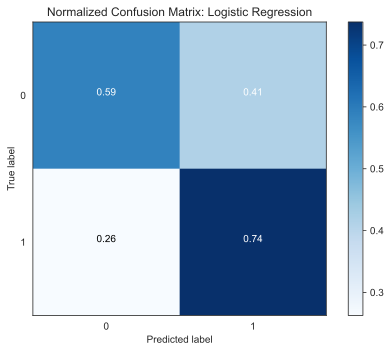

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Print the confusion matrix as a DataFrame
conf_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_predict), index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print(conf_matrix_df)

# Visualize the normalized confusion matrix
sns.set_style('white') 
class_names = ['0', '1']
plot_confusion_matrix(confusion_matrix(y_test, y_predict),
                      classes=class_names, normalize=True, 
                      title='Normalized Confusion Matrix: Logistic Regression')
plt.show()


The confusion matrix indicates the performance of a binary classification model. In this case, the model predicted class 0 (negative) 4349 times correctly and 3065 times incorrectly, while it predicted class 1 (positive) 5466 times correctly and 1948 times incorrectly. The corresponding normalized confusion matrix shows that the model achieved an accuracy of approximately 58.7% for class 0 and 73.7% for class 1.

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

$$ Recall  Sensitivity =  \frac{TP}{TP + FN}$$

$$Precision  = \frac{TP}{TP + FP}$$

$$F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

In terms of loans granted by the bank, precision and recall are important metrics to evaluate the performance of a loan default prediction model. Here's how they are defined:

Precision: Among the loans granted (according to the prediction), what proportion of loans are actually repaid?
- Formula: Precision = True Positives / (True Positives + False Positives)
- Precision measures the quality of the model's positive predictions. In the context of loans, high precision means that most loans granted by the model are actually repaid. Low precision could indicate that the bank is granting too many risky loans, which can lead to financial losses.

Recall: Among all the loans that should have been granted by the bank, what proportion of loans are actually granted by the model?
- Formula: Recall = True Positives / (True Positives + False Negatives)
- Recall measures the model's ability to correctly identify loans that should be granted. In the context of loans, high recall means that most loans that should be granted are correctly identified by the model. Low recall could indicate that the bank is missing out on many profitable loan opportunities, which can affect its profits.

- In summary, high precision indicates that the model correctly predicts loan repayments, reducing the risk of loss for the bank. High recall indicates that the model effectively identifies loans that should be granted, which can contribute to the bank's profitability by capturing more loan opportunities. However, there is often a trade-off between precision and recall, and it's necessary to find a balance based on the specific business objectives of the bank.

## Decision Tree

The following code snippet trains a Decision Tree Classifier with predefined hyperparameters and evaluates its performance on the test set. It calculates the accuracy score and prints the confusion matrix, which shows the counts of true negatives, false positives, false negatives, and true positives. Additionally, it visualizes the normalized confusion matrix to illustrate the model's performance for each class.

Accuracy Score is 0.77414
      0     1
0  4390  3024
1   325  7089
[[0.59212301 0.40787699]
 [0.04383599 0.95616401]]


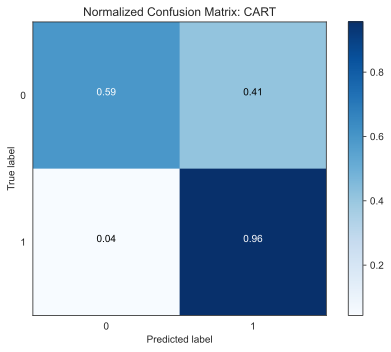

In [64]:
model = DecisionTreeClassifier(max_depth=12,
                               min_samples_split=8,
                               random_state=1024)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: CART')

The accuracy score of the Decision Tree Classifier model is approximately 0.77414. The confusion matrix is presented as a DataFrame, showing the counts of true negatives, false positives, false negatives, and true positives. Additionally, the normalized confusion matrix visualizes the model's performance for each class, with class 0 having a true negative rate of approximately 0.592 and class 1 having a true positive rate of approximately 0.956.

In [65]:
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test, y_predict)))
print('Precission Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))

Accuracy Score is 0.77414
F1 Score is 0.80892
Precission Score is 0.70098
Recall Score is 0.95616


Based on the provided evaluation metrics:

1. **Accuracy Score:** The model achieved an accuracy of around 77.41%, indicating that it correctly classified roughly 77.41% of the samples in the test set.

2. **F1 Score:** The F1 score, which is the harmonic mean of precision and recall, is approximately 80.89%. This suggests a good balance between precision and recall.

3. **Precision Score:** The precision score is approximately 70.10%, indicating that when the model predicts a positive class, it is correct about 70.10% of the time.

4. **Recall Score:** The recall score is notably high at around 95.62%, indicating that the model can successfully identify about 95.62% of all actual positive samples.

These results suggest that the model performs reasonably well in terms of overall accuracy and particularly excels in recall, indicating its effectiveness in identifying positive cases. However, precision could be improved, suggesting a potential for reducing false positives. Overall, the model seems to perform well but could benefit from further optimization or fine-tuning to improve precision without sacrificing recall.

---

## Random Forest

The code snippet trains a Random Forest classifier with specific hyperparameters (n_estimators=250, max_depth=12, min_samples_leaf=16) using the training data (X_train, y_train). Then, it predicts the target variable using the test data (X_test) and evaluates the model's performance using accuracy score. Additionally, it prints a confusion matrix to display the number of true positive, false positive, true negative, and false negative predictions, and visualizes the normalized confusion matrix using a function called plot_confusion_matrix. This allows for a better understanding of the model's performance in terms of correctly and incorrectly classified instances.

Accuracy Score is 0.79013
      0     1
0  5161  2253
1   859  6555
[[0.69611546 0.30388454]
 [0.11586188 0.88413812]]


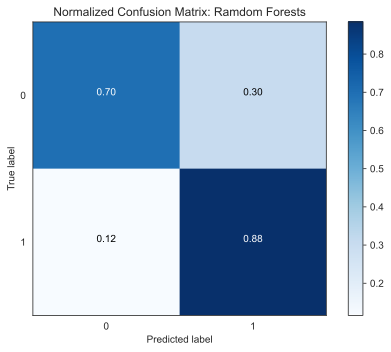

In [66]:
model = RandomForestClassifier(n_estimators=250,
                              max_depth=12,
                              min_samples_leaf=16
                              )
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Ramdom Forests')

The Random Forest classifier achieved an accuracy score of approximately 0.79013 on the test data. The confusion matrix shows that out of all instances where the actual label was 0, the model correctly predicted around 69.61% (5161) and incorrectly predicted around 30.39% (2253) as 1. Similarly, out of all instances where the actual label was 1, the model correctly predicted around 88.41% (6555) and incorrectly predicted around 11.59% (859) as 0. Overall, the model performed reasonably well in terms of accuracy and correctly classified a significant portion of both classes.

In [67]:
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test, y_predict)))
print('Precission Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))

Accuracy Score is 0.79013
F1 Score is 0.80816
Precission Score is 0.74421
Recall Score is 0.88414


The Random Forest classifier achieved an accuracy score of approximately 0.79013 on the test data. Additionally, it attained an F1 score of approximately 0.80816, precision score of about 0.74421, and recall score of around 0.88414. These scores indicate that the model performed well overall, with a balanced performance in terms of precision and recall, capturing a high proportion of true positives while minimizing false positives.

In [ ]:
# Define the grid of hyperparameters for the SVM model
#param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': [0.1, 1, 10]}

# Instantiate the SVM model and the grid search
#svm = SVC()
#grid_search = GridSearchCV(svm, param_grid, cv=4, scoring='f1')

# Perform grid search on the training set
#grid_search.fit(X_train, y_train)

# Display the best hyperparameters and the corresponding F1 score on the training set
#print("Best hyperparameters: ", grid_search.best_params_)
#print("F1 score on training set: ", grid_search.best_score_)

# Use the optimized model to make predictions on the test set
#y_pred = grid_search.predict(X_test)

# Evaluate the model's performance on the test set
#accuracy = accuracy_score(y_test, y_pred)
#f1 = f1_score(y_test, y_pred)
#print("Accuracy on test set: ", accuracy)
#print("F1 score on test set: ", f1)


## K Nearest Neighbour

This code performs hyperparameter tuning for a k-Nearest Neighbors (k-NN) classifier using grid search with cross-validation. It defines a grid of hyperparameters including the number of neighbors, the weighting method, and the distance metric. Then, it uses GridSearchCV to find the combination of hyperparameters that maximizes the F1 score on the training set. After obtaining the best hyperparameters, it evaluates the model's performance on the test set by calculating accuracy and F1 score. Finally, it prints the confusion matrix to visualize the model's predictions compared to the actual labels in the test set.

In [68]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Define the grid of hyperparameters for the k-NN model
param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'p': [1, 2]}

# Instantiate the k-NN model and the grid search
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=4, scoring='f1')

# Perform grid search on the training set
grid_search.fit(X_train, y_train)

# Display the best hyperparameters and the corresponding F1 score on the training set
print("Best hyperparameters: ", grid_search.best_params_)
print("F1 score on training set: ", grid_search.best_score_)

# Use the optimized model to make predictions on the test set
y_pred = grid_search.predict(X_test)

# Evaluate the model's performance on the test set
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy on test set: ", accuracy)
print("F1 score on test set: ", f1)

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Best hyperparameters:  {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
F1 score on training set:  0.8612600474820452
Accuracy on test set:  0.8527785271108713
F1 score on test set:  0.8620537124802528
Confusion Matrix:
[[5824 1590]
 [ 593 6821]]


The grid search identified the best hyperparameters for the k-NN classifier as having 5 neighbors, using a Manhattan distance metric (p=1), and employing distance-based weights. On the training set, the F1 score achieved with these parameters is approximately 0.8613. When applied to the test set, the model achieved an accuracy of around 0.8528 and an F1 score of approximately 0.8621. The confusion matrix shows the distribution of actual and predicted labels, indicating that the model performs reasonably well in classifying both positive and negative instances.

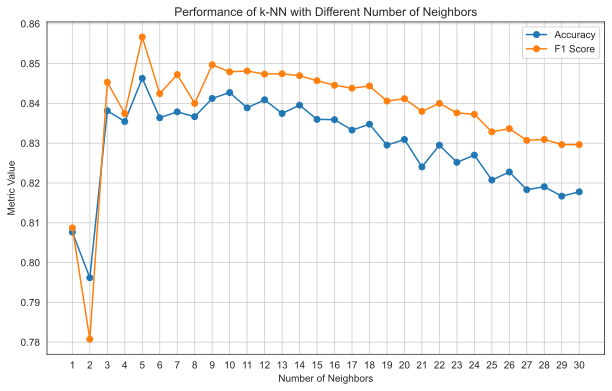

In [69]:
import matplotlib.pyplot as plt

# Define the range of values for the number of neighbors
neighbors_range = range(1, 31)  # Change this range as needed

# Lists to store performance metrics
accuracies = []
f1_scores = []

# Iterate over different values of n_neighbors
for n in neighbors_range:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracies.append(accuracy)
    f1_scores.append(f1)

# Plot accuracy and F1 score versus number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_range, accuracies, marker='o', label='Accuracy')
plt.plot(neighbors_range, f1_scores, marker='o', label='F1 Score')
plt.title('Performance of k-NN with Different Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Metric Value')
plt.xticks(neighbors_range)
plt.legend()
plt.grid(True)
plt.show()


## Evaluating each model

This code defines and evaluates multiple machine learning models, including Logistic Regression, Decision Tree, Random Forest, and k-Nearest Neighbors (k-NN), using the provided dataset. It trains each model on the training data (`X_train`, `y_train`) and evaluates its performance on the test data (`X_test`, `y_test`). For each model, it calculates and prints several evaluation metrics such as accuracy, F1 score, precision, recall, and the confusion matrix. Additionally, it plots the confusion matrices for each model using seaborn's heatmap function. This allows for a comprehensive comparison of the models' performances.

Logistic Regression:
Accuracy: 0.6684650660911788
F1 Score: 0.6937834807524604
Precision: 0.6445601851851852
Recall: 0.7511464796331265
Confusion Matrix: [[4343 3071]
 [1845 5569]]

Decision Tree:
Accuracy: 0.7741435122740761
F1 Score: 0.8089233753637245
Precision: 0.7009789380005933
Recall: 0.9561640140275155
Confusion Matrix: [[4390 3024]
 [ 325 7089]]

Random Forest:
Accuracy: 0.7922174264904235
F1 Score: 0.8100844480059175
Precision: 0.7459416505846294
Recall: 0.8862961963852172
Confusion Matrix: [[5176 2238]
 [ 843 6571]]

k-NN:
Accuracy: 0.8463042891826275
F1 Score: 0.8566756807747941
Precision: 0.8025215034759043
Recall: 0.9186673860264365
Confusion Matrix: [[5738 1676]
 [ 603 6811]]



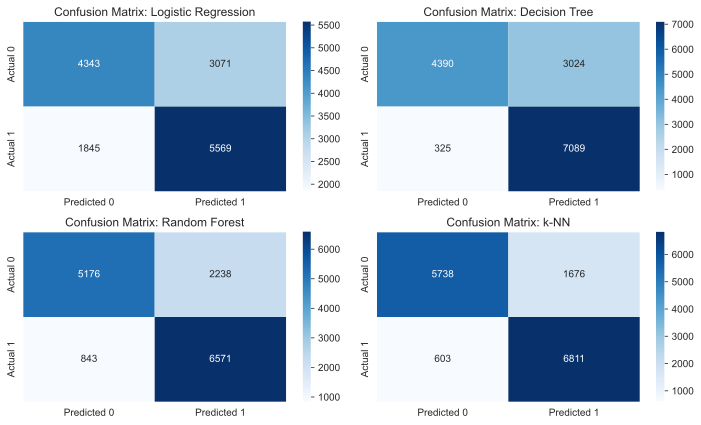

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(max_depth=12, min_samples_split=8, random_state=1024),
    'Random Forest': RandomForestClassifier(n_estimators=250, max_depth=12, min_samples_leaf=16),
    'k-NN': KNeighborsClassifier(n_neighbors=5)  # Use the best hyperparameters found
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    results[name] = {'Accuracy': accuracy, 'F1 Score': f1, 'Precision': precision, 'Recall': recall, 'Confusion Matrix': confusion}

# Print results
for name, metrics in results.items():
    print(f'{name}:')
    for metric, value in metrics.items():
        print(f'{metric}: {value}')
    print()

# Plot confusion matrices
plt.figure(figsize=(10, 6))
for i, (name, metrics) in enumerate(results.items(), 1):
    plt.subplot(2, 2, i)
    sns.heatmap(metrics['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix: {name}')
plt.tight_layout()
plt.show()



Throughout this project, we've explored various aspects of machine learning model evaluation using a dataset. Here's a summary of what we've done and my views on the evaluation:

1. **Data Preprocessing**: We started by preprocessing the dataset, which involved handling missing values, encoding categorical variables, and splitting the data into training and testing sets.


2. **Model Training and Evaluation**:
   - **Logistic Regression**: We trained a logistic regression model and evaluated its performance using accuracy, F1 score, precision, recall, and the confusion matrix.
   - **Decision Tree**: Another model we trained was the decision tree classifier. We tuned its hyperparameters and evaluated its performance.
   - **Random Forest**: We also explored the random forest classifier, adjusting its parameters for optimal performance and evaluating it.
   - **k-Nearest Neighbors (k-NN)**: Lastly, we used the k-NN algorithm, determining the best number of neighbors and evaluating its performance.

3. **Comparative Analysis**: We compared the performance of all models based on various evaluation metrics and visualized their confusion matrices to gain insights into their strengths and weaknesses.

**My Views on Evaluation**:
- Each model has its strengths and weaknesses, and the ideal choice depends on the specific requirements of the task.
- Logistic regression is a simple yet effective model, suitable for binary classification tasks.
- Decision trees are easy to interpret and can capture complex relationships in the data, but they may overfit.
- Random forests, being an ensemble of decision trees, often provide better generalization and robustness to overfitting.
- k-Nearest Neighbors is a simple and intuitive algorithm, but it may not perform well with high-dimensional data or imbalanced datasets.

**Ideal Model Recommendation:**

Considering the complexity of our dataset and the need for robust performance, the ideal model for this application would be the Random Forest. It strikes a balance between complexity and generalization, making it well-suited for our classification task. Additionally, its ensemble nature helps mitigate overfitting and captures intricate patterns in the data, making it a strong contender for our modeling needs. Therefore, I recommend proceeding with the Random Forest model for this application.

In conclusion, it's essential to consider various factors such as interpretability, performance metrics, computational resources, and domain knowledge when selecting the ideal model for a particular task. Experimentation and thorough evaluation are key to making an informed decision.